In [1]:
from matplotlib import pyplot as plt
import seaborn as sbn
from atus import summary as sm
from atus import codes
import re
%matplotlib inline

In [2]:
no_children = 'summary.TRCHILDNUM == 0'
have_children = 'summary.TRCHILDNUM != 0'
adults = 'summary.TEAGE >= 18'
non_adults = 'summary.TEAGE < 18'
working = '(summary.TELFS == 1) | (summary.TELFS == 2)'
not_working = 'not ((summary.TELFS == 1) | (summary.TELFS == 2))'
income = 'summary.TRERNWA > 0'

childless_working_adult = [no_children, adults, working]
withchild_working_adult = [have_children, adults, working]

work_time = [item for item in sm.codes() if re.match(r't05[0-9]{4}', item)]

leisure_time = [item for item in sm.codes() if \
           re.match(r't12[0-9]{4}|t13[0-9]{4}|t14[0-9]{4}|t160101|t160102|t160299', item)]

On average adults with no children who work spend 5.3 hours per day working
----

In [3]:
print(round(sm.mean_over_columns(work_time, childless_working_adult)/60, 2), 'hours working')

5.3 hours working


and relax 4.5 hours per day
---

In [4]:
print(round(sm.mean_over_columns(leisure_time, childless_working_adult)/60, 1), 'hours relaxing')

4.5 hours relaxing


those with children who work spend 5.22 hours per day working
---

In [5]:
print(round(sm.mean_over_columns(work_time, withchild_working_adult)/60, 2), 'hours working')

5.22 hours working


and relax 3.7 hours per day
----

In [6]:
print(round(sm.mean_over_columns(leisure_time, withchild_working_adult)/60, 1), 'hours relaxing')

3.7 hours relaxing


# Breakdown of weekly income by age group (10-year bins):
(restricted to adults who work)
------
 |setup bins|

In [7]:
blocks = sm.range_blocks(20, 60, 10)
age_ranges = []
for item in blocks:
    age_ranges.append('{} <= summary.TEAGE'.format(item[0]))
    age_ranges.append('summary.TEAGE < {}'.format(item[1]))

weekly income by age.  Blue = mean for age range, Red = mean by age
------

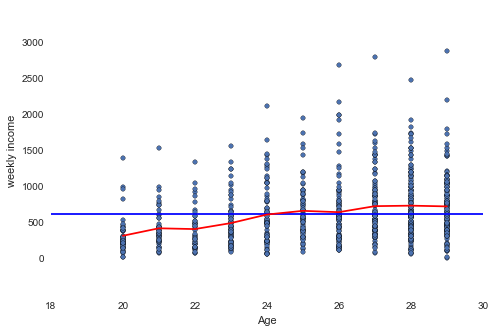

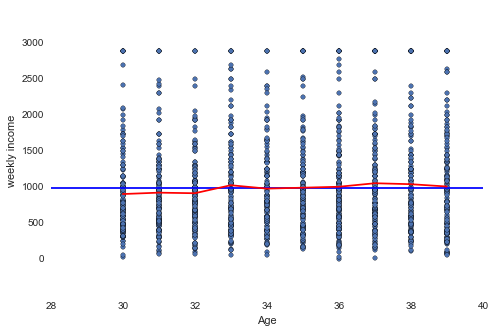

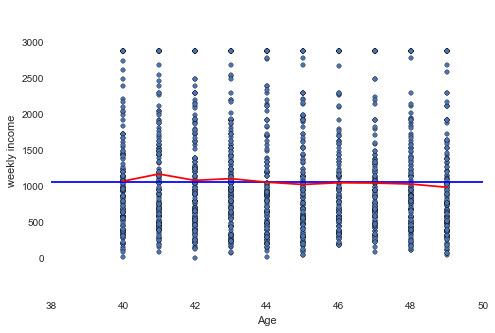

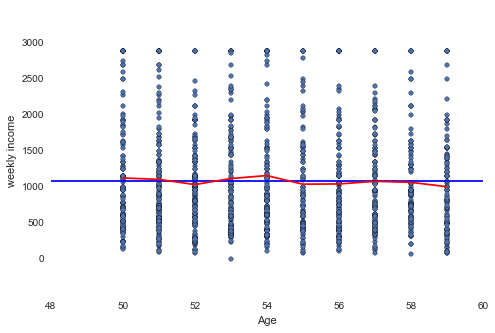

In [8]:
for idx in range(len(age_ranges))[::2]:
    conditions = [age_ranges[idx], age_ranges[idx+1], income, working, adults]
    sm.graph_selection(['TEAGE', 'TRERNWA'], conditions)
    plt.xlabel('Age')
    plt.ylabel('weekly income')
    plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
    plt.axhline(y=sm.mean_over_columns(['TRERNWA'], conditions, weighted=False))
    
    block = range(*blocks[idx//2])
    means = []
    for idx in block:
        age = 'summary.TEAGE == {}'.format(idx)
        means.append(sm.mean_over_columns(['TRERNWA'], [age, income, working, adults], weighted=False))
    plt.plot(block, means, color='r')
    plt.yticks(range(0, 3001)[::500])
    plt.show()

# Hourly wage vs hours worked

Correlation score:  0.416


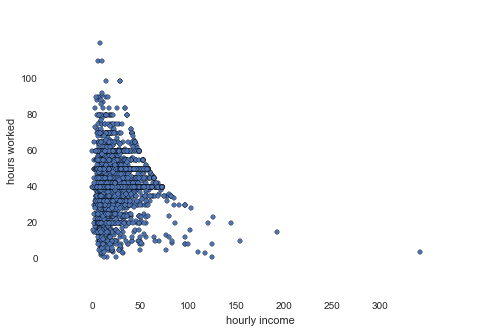

In [9]:
age_high = '80 > summary.TEAGE'
age_low = 'summary.TEAGE > 20'  # 20 - 80 years old
hours = 'summary.TEHRUSLT > 0'  # work more than 0 hours
income = 'summary.TRERNWA > 0'  # make more than 0 dollars

conditions = [income, age_high, age_low, hours, income]

sm.graph_selection(['hourly', 'TEHRUSLT'], conditions)

plt.ylabel('hours worked')
plt.xlabel('hourly income')
plt.xticks(range(0, 350)[::50])
plt.yticks(range(0, 120)[::20])
plt.subplots_adjust(bottom=1, top=2, left=1, right=2)
sbn.set_context('poster')

print('Correlation score: ', round(sm.correlate(['TEHRUSLT', 'TRERNWA'], conditions), 3))

by income level (300 dollars/week bins):
------

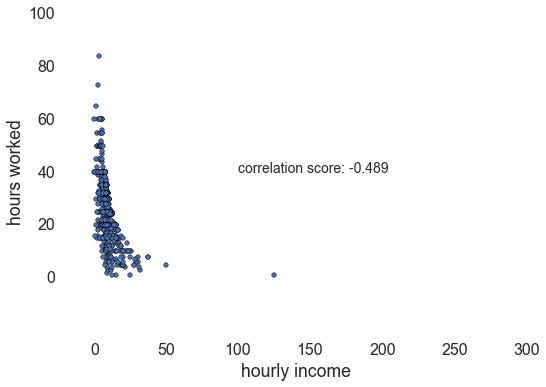

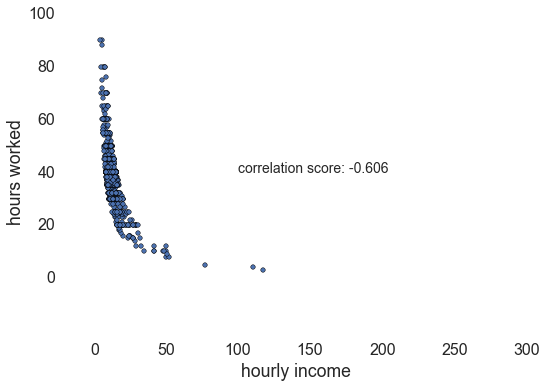

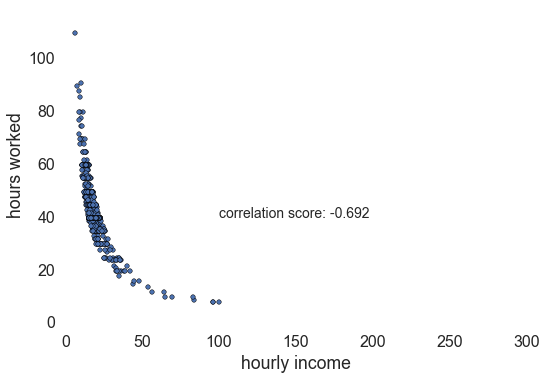

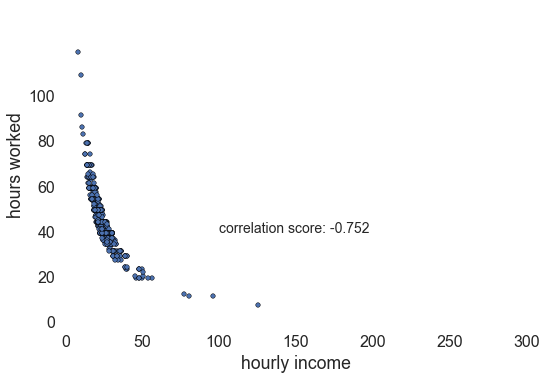

In [10]:
blocks = sm.range_blocks(0, 1200, 300)
corr_scores = []
for item in blocks:
    weekly1 = '{} < summary.TRERNWA'.format(item[0])
    weekly2 = 'summary.TRERNWA <= {}'.format(item[1])
    conds = [income, age_high, age_low, hours, weekly1, weekly2]
    
    sm.graph_selection(['hourly', 'TEHRUSLT'], conds)
    corr_scores.append(sm.correlate(['hourly', 'TEHRUSLT'], conds))
    
    plt.text(x=100, y=40, s='correlation score: {}'.format(round(corr_scores[blocks.index(item)], 3)), size=14)
    plt.ylabel('hours worked')
    plt.xlabel('hourly income')
    plt.xticks(range(0, 350)[::50])
    plt.yticks(range(0, 120)[::20])
    plt.subplots_adjust(left=1, right=1.5, bottom=1, top=1.5)

# the bin positions are not a factor:

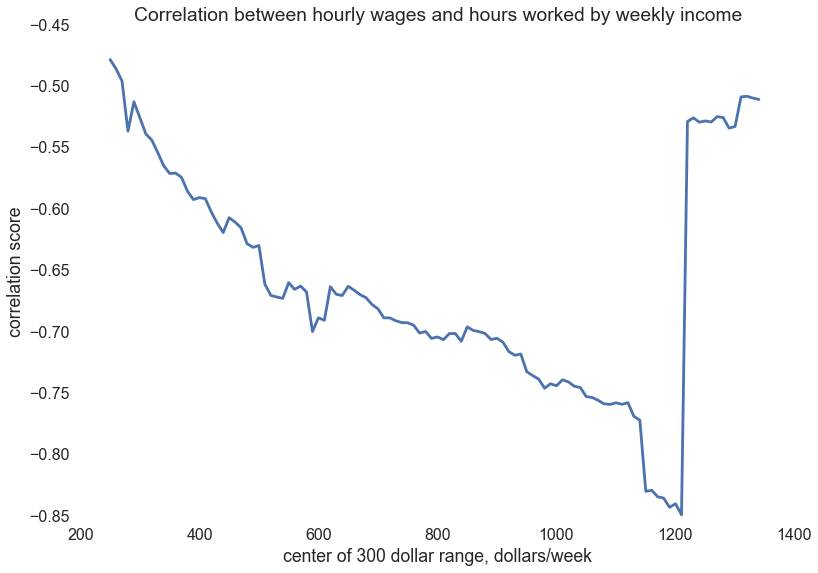

In [11]:
corr_score = []
ranges = []
for item in range(100, 1200)[::10]:
    income_low =  '{} < summary.TRERNWA'.format(item)
    income_high = 'summary.TRERNWA <= {}'.format(item + 300)
    conds = [income_low, income_high, age_high, age_low, hours]
    
    ranges.append(item + 150)
    corr_score.append(sm.correlate(['hourly', 'TEHRUSLT'], conds))
    
plt.plot(ranges, corr_score)
plt.xlabel('center of 300 dollar range, dollars/week')
plt.ylabel('correlation score')
plt.title('Correlation between hourly wages and hours worked by weekly income')

# Conclusion: up to a point, if someone makes more per hour they are more likely to work less than someone with a similar weekly income.

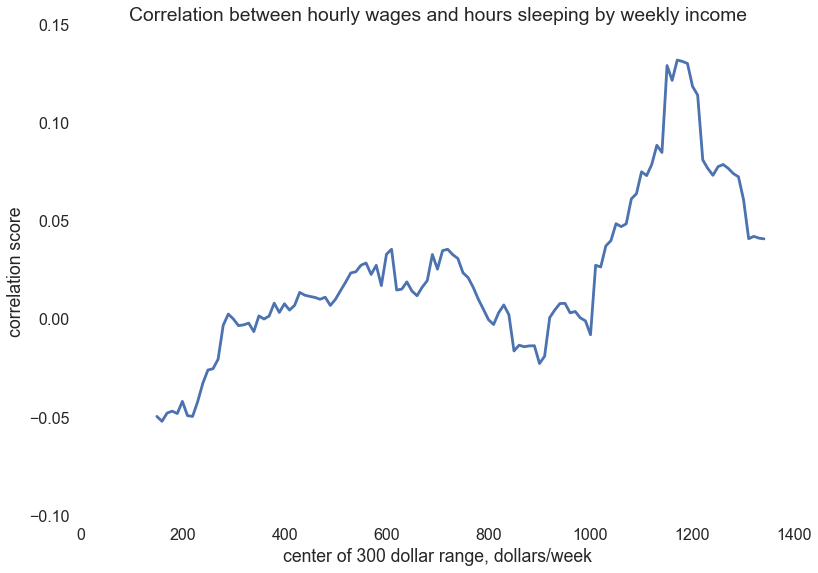

In [12]:
corr_score = []
ranges = []
for item in range(0, 1200)[::10]:
    income_low =  '{} < summary.TRERNWA'.format(item)
    income_high = 'summary.TRERNWA <= {}'.format(item + 300)
    conds = [income_low, income_high, age_high, age_low, hours]
    
    ranges.append(item + 150)
    corr_score.append(sm.correlate(['hourly', 't010101'], conds))
    
plt.plot(ranges, corr_score)
plt.xlabel('center of 300 dollar range, dollars/week')
plt.ylabel('correlation score')
plt.title('Correlation between hourly wages and hours sleeping by weekly income')

## It doesn't change how much they sleep.




# What do the different income ranges do with their time?

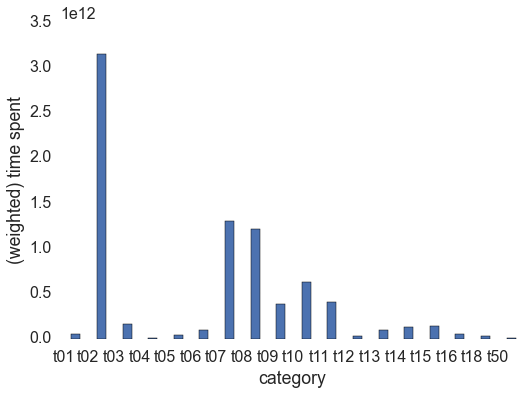

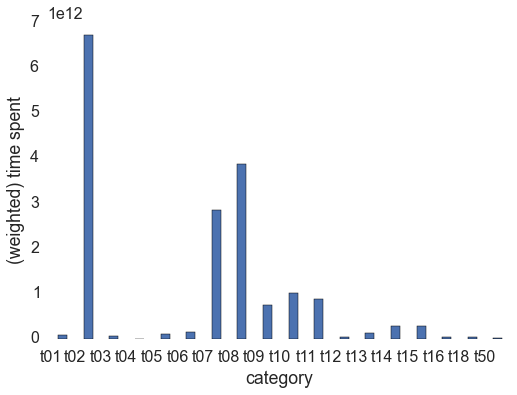

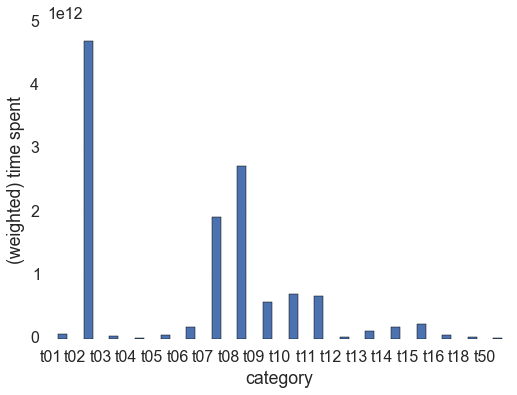

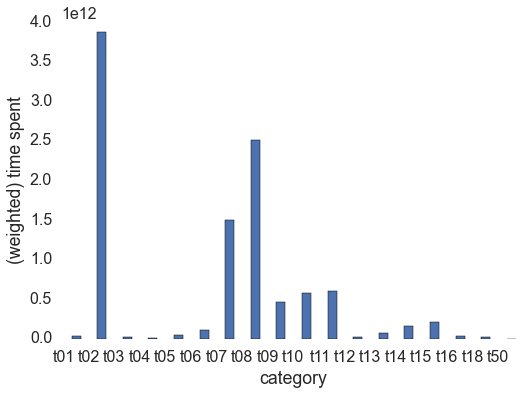

In [14]:
blocks = sm.range_blocks(0, 1200, 300)
major_codes = [item for item in codes.codes() if re.match(r't[0-9]{2}$', item)]
categories = {code: [subcode for subcode in sm.codes() if re.match(r'{}'.format(code), \
                                                                 subcode)] for code in major_codes}

for item in blocks:
    fig, ax = plt.subplots()
    values = []
    weekly1 = '{} < summary.TRERNWA'.format(item[0])
    weekly2 = 'summary.TRERNWA <= {}'.format(item[1])
    conds = [income, age_high, age_low, hours, weekly1, weekly2]
    
    for cat in categories:
        values.append(sm.sum_over_columns(categories[cat], conds))
    
    length = [item + .35 for item in range(len(major_codes))]
    
    plt.bar(length, values, .35)
    plt.ylabel('(weighted) time spent')
    plt.xlabel('category')
    ax.set_xticks(range(len(major_codes)))
    ax.set_xticklabels(major_codes)
    plt.subplots_adjust(left=1, right=1.5, bottom=1, top=1.5)

## There are similar curves for each of these graphs, the easiest to spot differences are t07 and t08.
These correspond to Consumer purchases and Professional/Personal Care Services.
----

The next most noticeable difference is in t11, t12, t15 and t16.  These are Eating/Drinking, Socializing/Relaxing, Volunteer Activities and Telephone Calls. 
----

In all of these cases you see an increase with income level.
----

This is probably not unexpected.